## How to use the lightning NetCDF files

This notebook steps through how to open the files and gives a small example of using established packages to make a quick map.

If you have already installed dask (in terminal: `conda install dask`) and the files are in good order, all have the same variables, and are available locally, then this will work:

    xr.open_mfdataset('<path-to-data>/Cloud_to_Ground_Lightning/US/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('<path-to-data>/Cloud_to_Ground_Lightning/US/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])

If you don't have them locally, then you can use list of OPeNDAP URLs instead of the wildcard notation.

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is where my data path is set
from lightning_setup import out_path

%matplotlib inline

In [20]:
ds = xr.open_mfdataset(out_path+'1993_*_*.nc', concat_dim='record')

## Grid

Once we have all the settings and imports, we should grid the data. The main thing that makes lightning different from other datasets is that it is a point process, so when we grid and aggregate we want to count strikes per grid cell rather than interpolating. This is a good [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about doing that. The premise is that we want to count the strikes within each bin, so we can use a 2D histogram.

In [3]:
x = ds.lon.values
y = ds.lat.values

gridx = np.linspace(x.min(), x.max(), 500)
gridy = np.linspace(y.min(), y.max(), 500)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

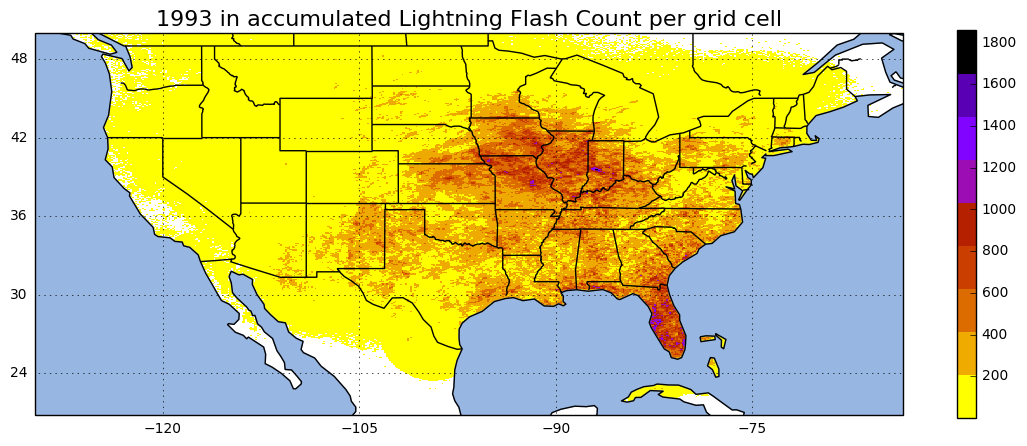

In [4]:
# define a good lightning colormap
cmap = mpl.cm.get_cmap('gnuplot_r', 9)
cmap.set_under('None')

#initiate a figure
plt.figure(figsize=(14,5))
ax = plt.axes(projection=ccrs.PlateCarree())

#add some geographic identifying features
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states)
gl = ax.gridlines(draw_labels=True, zorder=4)
gl.xlabels_top = False
gl.ylabels_right = False

# draw the data over top of this template
den = ax.imshow(density, cmap=cmap, interpolation='None', vmin=1,
                extent=[gridx.min(),gridx.max(), gridy.min(), gridy.max()])
plt.title('1993 in accumulated Lightning Flash Count per grid cell', fontsize=16)
plt.colorbar(den, ax=ax)
plt.savefig('./output/US_1993.png')

In [5]:
ds.close()